# Task 2: Sentiment Analysis Using Neural Networks

### A1. Summarize one research question that you will answer using a neural network model and NLP techniques

<p>The research question that I will answer using a neural network model and NLP techniques is: How effectively can a neural network classify movie reviews as positive or negative using sentiment analysis? This research question is relevant to real-world businesses, as movie studios and streaming platforms use sentiment analysis to understand audience reactions to movies. This helps them make decisions related to marketing, content curation, and targeted recommendations. The research question also aligns with the IMDb dataset, which contains movie reviews labeled as either positive (1) or negative (0).</p>

### A2. Define the objectives or goals of the data analysis

<p>There are two key goals in this data analysis. The first goal is to develop a neural network model that classifies movie reviews as positive or negative. The second goal is to evaluate the classification performance of the model. Both goals align with the research question and are represented in the IMDb dataset.</p>

### A3. Identify an industry-relevant type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected dataset

<p>The neural network model I will use for this movie classification task is <b>Long Short-Term Memory (LSTM)</b>, which is a type of Recurrent Neural Network (RNN). I chose LSTM because it handles sequential data efficiently by remembering past words and their influence on the sentiment. Also, unlike standard RNNs, LSTMs prevent the vanishing gradient problem, which helps them "learn and retain information over longer sequences" (Xu, 2024, par. 15). Additionally, LSTMs are widely used in sentiment analysis tasks.</p>

### B1. Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements: presence of unusual characters (e.g., emojis, non-English characters), vocabulary size, word embedding length, and statistical justification for the chosen maximum sequence length.

In [1]:
import tensorflow as tf
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import random
import string

np.random.seed(24)  
random.seed(24)  
tf.random.set_seed(24)  

file = 'imdb_labelled.txt'
df = pd.read_csv(file, delimiter="\t", header=None, names=["review", "label"])

<p>In this code, I loaded the IMDb dataset into a Pandas DataFrame using the read_csv() function. I also assigned column names, where "review" represents the test data and "label" represents the sentiment, with 0 for negative and 1 for positive.</p>

In [2]:
df.head()

,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


<p>In this code, I used the head() function to display the first five rows of the dataset. Each row contains a movie review and its corresponding sentiment label.</p>

In [3]:
df.shape

(748, 2)

<p>In this code, I displayed the shape of the dataset. It contains 748 rows (movie reviews) and 2 columns (review and label).</p>

In [4]:
print(df.isnull().sum())

review    0
label     0
dtype: int64


<p>In this code, I checked for missing values in each column by summing up null entries. There are no missing values in either column (review or label).</p>

In [5]:
df.duplicated().sum()

3

<p>In this code, I checked for duplicate rows in the dataset using both the duplicated() and sum() functions. There are 3 duplicate rows in the dataset.</p>

In [6]:
df = df.drop_duplicates()
df.shape

(745, 2)

<p>In this code, I removed the duplicate rows from the dataset using the drop_duplicates() function. The dataset now contains 745 unique rows.</p>

<Axes: >

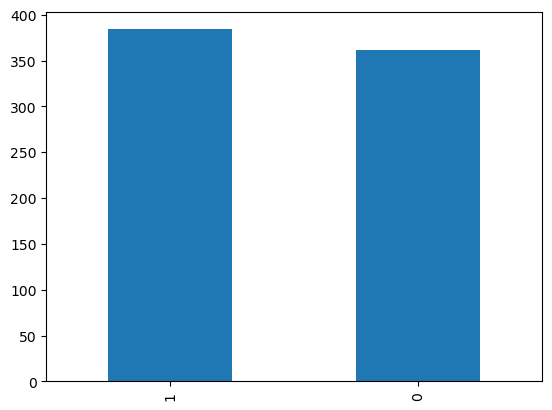

In [7]:
df.label.value_counts().plot(kind='bar')

<p>In this code, I created a bar plot to show the number of positive (1) and negative (0) sentiment labels. The dataset has about the same number of each, so it is balanced.</p>

#### Presence of unusual characters (e.g., emojis, non-English characters)

In [8]:
#function that detects non-English characters and emojis
def find_unusual_characters(text):
    unusual_pattern = re.compile(r'[^\x00-\x7F]')  #this regular expression matches any non-ASCII character
    return unusual_pattern.findall(text)

#applying find_unusual_characters function to all movie reviews and collecting unique characters
all_unusual_chars = set()
df["review"].apply(lambda x: all_unusual_chars.update(find_unusual_characters(x)))

print("Unique Non-English Characters and Emojis Found:")
print(sorted(all_unusual_chars))

Unique Non-English Characters and Emojis Found:
['\x85', '\x96', '\x97', 'å', 'é']


<p>In this code, I created a function (find_unusual_characters) that uses a regular expression to detect non-English or emoji characters in movie reviews. The function looks for characters outside the ASCII range, including accented letters, emojis, and special symbols. The function extracts these characters from each review, storing only unique ones in a set. I displayed a list of all unique non-English characters and emojis found in the dataset.</p>

<p>The dataset has five unique non-English characters: '\x85', '\x96', '\x97', 'å', 'é'. Two of them ('å', 'é') are non-English accented letters, while the other three ('\x85', '\x96', '\x97') are hexadecimal representations of special ASCII characters. There are no emojis found in the dataset.</p>

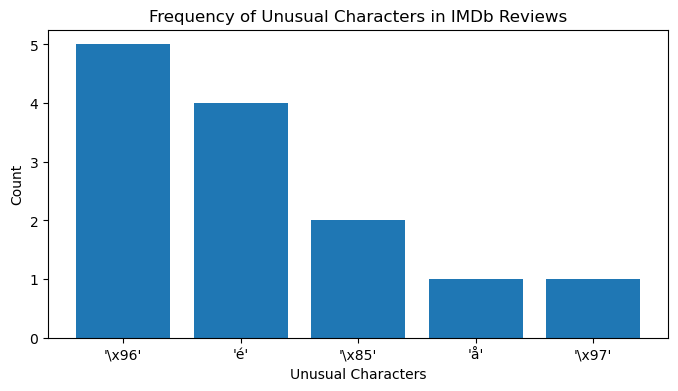

In [9]:
from collections import Counter

#counting occurrences of each unusual character
char_counts = Counter()

df["review"].apply(lambda x: char_counts.update(find_unusual_characters(x)))

#converting the keys to hex string representations
labels = [repr(char) for char in char_counts.keys()]

#plotting bar chart
plt.figure(figsize=(8, 4))
plt.bar(labels, char_counts.values())
plt.title("Frequency of Unusual Characters in IMDb Reviews")
plt.xlabel("Unusual Characters")
plt.ylabel("Count")
plt.show()

<p>This bar chart shows how often unusual characters appear in the IMDb dataset. The most common is '\x96', which appears 5 times. 'é', an accented non-English character, shows up 4 times. The other characters ('\x85', 'å', '\x97') appear only once or twice. Although these characters are rare and not a major issue, I will still remove them in the next step to reduce noise and keep the data clean.</p>

#### Vocabulary size

In [10]:
#function that calculates the vocab size of movie reviews
def get_vocabulary_size(texts):
    words = [word for text in texts for word in text.split()]
    return len(set(words))

#applying get_vocabulary_size function to all movie reviews
vocab_size = get_vocabulary_size(df['review'])

print("Vocabulary Size:", vocab_size)

Vocabulary Size: 4248


<p>In this code, I created a function (get_vocabulary_size) that calculates the vocabulary size of movie reviews in the IMDb dataset. It splits each review into individual words, collects all words in a list, and converts the list into a set to remove duplicates. The function then returns the number of unique words. I applied the function to the review column of the dataset and displayed the calculated vocabulary size.</p>

<p>The dataset contains 4,248 unique words across all movie reviews, but the text hasn't been cleaned. For example, "Good" and "good" are counted as different words, and "amazing!" and "amazing" are treated separately. Common stopwords like "the", "is", and "and" are also included, which increases the vocabulary size. In the next code, I used a similar function that lowercases the text, removes punctuation, special symbols, and stopwords, and applies lemmatization to get a more accurate vocabulary size.</p>

In [11]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#initializing lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

#function that calculates the vocab size after cleaning and lemmatizing the text
def get_clean_vocabulary_size(texts, return_tokens=False):
    all_tokens = [
        lemmatizer.lemmatize(
            re.sub(r'\W+', '', word.lower())
        )
        for text in texts
        for word in text.split()
        if word.strip() and word.lower() not in stop_words
    ]

    #if return_tokens is true, it runs this if statement and returns cleaned tokenized reviews
    if return_tokens:
        tokenized_reviews = [
            [
                lemmatizer.lemmatize(
                    re.sub(r'\W+', '', word.lower())
                )
                for word in text.split()
                if word.strip() and word.lower() not in stop_words
            ]
            for text in texts
        ]
        return tokenized_reviews
    else:
        return len(set(all_tokens))

#applying get_clean_vocabulary_szie function to all movie reviews
vocab_size = get_clean_vocabulary_size(df['review'])

print("Vocabulary Size (after cleaning + lemmatization):", vocab_size)

Vocabulary Size (after cleaning + lemmatization): 2907


<p>In this code, I created a function called get_clean_vocabulary_size() that calculates the vocabulary size after cleaning and lemmatizing the text. If the "return_tokens" parameter is set to "True", it can also return the cleaned, tokenized reviews, which I will use later to calculate the maximum sequence length. The function lowercases each word, removes punctuation, special characters, and stopwords, and applies lemmatization to reduce words to their base form. It then keeps only unique words and returns the total count. I applied this function to the review column and displayed the resulting vocabulary size.</p>

<p>After cleaning and applying lemmatization to the text, the vocabulary size dropped to 2,907. This is because duplicates caused by case differences were removed, words like "Good" and "good" now count as one. Punctuation was also removed, so "amazing!" and "amazing" are treated as the same word. Common stopwords like "is", "the", and "and" were taken out, and word variations like "running", "runs", and "ran" were all reduced to their base form, "run", with the help of lemmatization.</p>

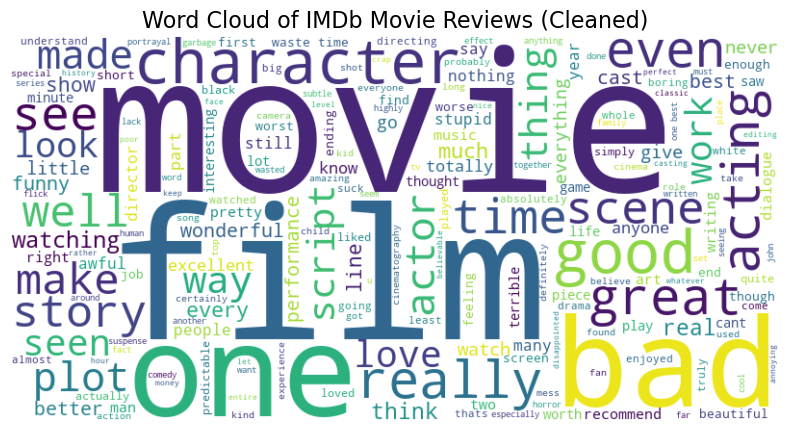

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cleaned_tokens = get_clean_vocabulary_size(df['review'], return_tokens=True)

all_text = ' '.join([' '.join(tokens) for tokens in cleaned_tokens])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of IMDb Movie Reviews (Cleaned)', fontsize=16)
plt.show()

<p>This word cloud shows the most common words in the IMDb dataset after cleaning the reviews. The largest words include "movie", "film", "character", "acting", "story", "good", "bad", and "really", which means these terms appear most often. Emotionally charged words like "good", "bad", "funny", "real", "boring", and "amazing" are also present in different sizes, showing that the reviews contain strong opinion-based language. Common stopwords like "the", "and", and "is" are no longer visible, and all words are shown in their base forms. This confirms that the cleaning process was effective. Overall, the dataset is now well-prepared for sentiment classification.</p>

#### Word embedding length

In [13]:
if vocab_size < 10_000:
    custom_embedding_dim = 50  #small dataset = smaller embedding size
elif vocab_size < 50_000:
    custom_embedding_dim = 100  #medium dataset = moderate embedding size
else:
    custom_embedding_dim = 200  #large dataset = higher embedding size

print(f"Chosen Word Embedding Length: {custom_embedding_dim}")

Chosen Word Embedding Length: 50


<p>Word embedding length is the number of values used to represent each word as a numerical vector. It helps the model understand the meaning and context of words. Words with similar meanings are placed closer together in this space. For a vocabulary of 2,907, using a 50-dimensional word embedding is a good starting point. Since the dataset is small, a larger embedding size would make the model more complex without much benefit. On the other hand, an embedding size that is too small might not capture enough meaning. A word embedding dimension of 50 is commonly used for small datasets like IMDb reviews, which is why I chose it for this task.</p>

#### Statistical justification for maximum sequence length

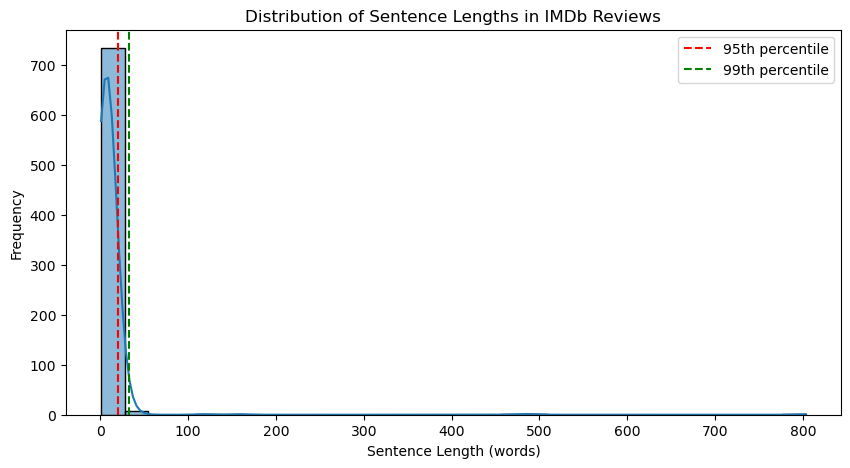


Chosen Maximum Sequence Length: 20 words (covers 95% of reviews)


In [14]:
#cleaning and tokenizing the reviews in the dataset
temp_tokens = get_clean_vocabulary_size(df['review'], return_tokens=True)

#counting the number of words in each review and storing it in a Pandas Series
sentence_lengths = pd.Series([len(tokens) for tokens in temp_tokens])

#plotting the distribution of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.axvline(np.percentile(sentence_lengths, 95), color='red', linestyle='dashed', label='95th percentile')
plt.axvline(np.percentile(sentence_lengths, 99), color='green', linestyle='dashed', label='99th percentile')
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths in IMDb Reviews")
plt.legend()
plt.show()

#calculating the 95th percentile sentence length
max_seq_length = int(np.percentile(sentence_lengths, 95))
print(f"\nChosen Maximum Sequence Length: {max_seq_length} words (covers 95% of reviews)")

<p>In this code, I analyzed the distribution of review lengths in the IMDb dataset to determine the best maximum sequence length for an LSTM model using statistical reasoning. I started by using the get_clean_vocabulary_size() function from earlier to clean and tokenize the reviews in the dataset. Next, I counted the number of words in each review and stored it in a Pandas Series. Then, I used the hisplot() function to create a histogram showing the distribution of review lengths. To visualize cutoff points, I added a red dashed line at the 95th percentile, meaning 95% of reviews are shorter than this length, and a green dash line at the 99th percentile, meaning 99% of reviews are shorter than this length. Finally, I selected the 95th percentile as the maximum sequence length, ensuring that only the longest 5% of reviews are truncated, while keeping most reviews intact.</p>

<p>The histogram shows most reviews are short, with a few very long ones. The 95th percentile is 20 words, meaning 95% of reviews have 20 words or fewer. The 99th percentile is higher, but I chose not to use it since longer reviews add unnecessary computational complexity. So, the best maximum sequence length for the LSTM model is 20. Reviews longer than 20 words will be truncated, while shorter ones will be padded to this length.</p>

### B2. Describe the goals of the tokenization process, including any code generated and any packages that are used to normalize text during the process

<p>Tokenization is an important preprocessing step for sentiment analysis with an LSTM model and has several goals. The first goal is to split sentences into words so they can be easily processed by machine learning models like LSTM. The second goal is to remove irrelevant elements such as punctuation, stopwords, and special characters to reduce noise. The third goal is to make the text consistent by converting it to lowercase and applying lemmatization, which reduces words to their base form. The fourth and final goal is to prepare text for word embeddings. I applied tokenization and normalization to the IMDb movie reviews, as shown in the code below.</p>

In [15]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

#initializing lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_and_tokenize(text):
    #converting text to lowercase
    text = text.lower()

    #removing punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    #tokenizing words
    tokens = word_tokenize(text)

    #removing stopwords and applying lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

#applying tokenization to dataset
df["tokens"] = df["review"].apply(clean_and_tokenize)

#displaying tokenized output
print(df[["review", "tokens"]].head())

                                              review  \
0  A very, very, very slow-moving, aimless movie ...   
1  Not sure who was more lost - the flat characte...   
2  Attempting artiness with black & white and cle...   
3       Very little music or anything to speak of.     
4  The best scene in the movie was when Gerardo i...   

                                              tokens  
0  [slowmoving, aimless, movie, distressed, drift...  
1  [sure, lost, flat, character, audience, nearly...  
2  [attempting, artiness, black, white, clever, c...  
3                   [little, music, anything, speak]  
4  [best, scene, movie, gerardo, trying, find, so...  


<p>In this code, I created a function called clean_and_tokenize() to clean and tokenize movie reviews from the IMDb dataset. It first converts the text to lowercase using the lower() function. Then, it removes punctuation and special characters to eliminate noise that doesn't help with sentiment analysis. After that, it splits the text into individual words using the word_tokenize() function. Finally, it removes common English stopwords like "the", "is", and "and", and applies lemmatization to reduce words to their base form. I applied this function to each review in the dataset, adding a new column "tokens" that contains the cleaned and tokenized words. I then displayed the first few rows to show the original reviews alongside their tokenized versions.</p>

<p>Looking at the output, all tokens are now lowercase for consistency. Punctuation marks like commas, periods, and hyphens have been removed. Common words such as "the", "is", and "and" were also taken out because they don't add much to sentiment analysis. Lemmatization turned words into their simplest forms. The remaining tokens are meaningful words that can be used for further processing.</p>

<p>I used two packages for tokenization and normalization. The first is NLTK (Natural Language Toolkit), which provides functions like WordNetLemmatizer() to reduce words to their base form, word_tokenize() to split text into individual words, and stopwords() to remove common English words like "the", "is", and "and". The second package is re (Regular Expressions), which I used with the sub() function to remove punctuation and special characters from the text.</p>

### B3. Explain the padding process used to standardize the length of sequences. Include the following in your explanation: whether the padding occurs before or after the text sequence and a screenshot of a single padded sequence

<p>Padding is used to "ensure all sequences have the same length" (Natarajan, 2020, par. 2), which is important because models like LSTMs require uniform input sequences. It adds zeros to shorter sequences and, with truncation, cuts off longer ones to match a fixed maximum sequence length, helping reduce computational load. Before applying padding, the word tokens must be converted into integer sequences, which I did in the code below.</p>

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#initializing tokenizer with vocab size of 2907 based on cleaned vocab size found earlier
tokenizer = Tokenizer(num_words=2907, oov_token="<OOV>")
tokenizer.fit_on_texts(df["tokens"])  # tokens = list of token lists

#converting all token lists into integer sequences
sequences = tokenizer.texts_to_sequences(df["tokens"])

#applying padding to make all sequences the same length. Using max sequence length of 20, padding=post, and truncating=post
padded_sequences = pad_sequences(sequences, maxlen=20, padding='post', truncating='post')

#adding sequences to the dataset as a new column
df["sequences"] = list(padded_sequences)

#displaying original tokens and alongside their numerical sequences
print(df[["tokens", "sequences"]].head())

                                              tokens  \
0  [slowmoving, aimless, movie, distressed, drift...   
1  [sure, lost, flat, character, audience, nearly...   
2  [attempting, artiness, black, white, clever, c...   
3                   [little, music, anything, speak]   
4  [best, scene, movie, gerardo, trying, find, so...   

                                           sequences  
0  [1045, 1046, 2, 1047, 1048, 307, 73, 0, 0, 0, ...  
1  [419, 308, 614, 8, 241, 1049, 201, 615, 0, 0, ...  
2  [1050, 1051, 110, 121, 242, 140, 420, 2, 202, ...  
3  [52, 74, 166, 421, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [26, 17, 2, 1053, 309, 96, 141, 204, 617, 422,...  


<p>In this code, I converted the word tokens into integer sequences, applied padding and truncation to make all sequences the same length, and stored the sequences in a new column in the dataset. I started by initializing the Tokenizer, limiting the vocabulary to the top 2,907 most frequent words, which is based on the cleaned vocabulary size found earlier. I also added an OOV (out-of-vocabulary) token to handle words not in the vocabulary, so the model can deal with unseen input. Next, I used the fit_on_texts() function to build the vocabulary from the "tokens" column. Then, I used the texts_to_sequences() function to convert each list of tokens into a list of integer IDs, with unknown words replaced by the OOV token. Finally, I used the pad_sequences() function with the parameters "maxlen=20", "padding=post", and "truncating=post" to make sure all sequences are exactly 20 tokens long. This adds zeros to the end of shorter sequences and cuts off extra words at the end of longer ones. The sequences were added to the dataset, and I displayed the first few rows to show the original tokens alongside their numerical sequences.</p>

<p>The output shows tokenized reviews and numerical sequences for each tokenized review. Each word is replaced with its unique integer ID from the tokenizer's vocabulary. Zeros are added at the end of most sequences to make sure all of them are exactly 20 tokens long.</p>

#### Whether the padding occurs before or after the text sequence

<p>Since I used the parameter "padding=post" in the pad_sequences() function, padding is added after each text sequence. This means zeros are placed at the end of any sequence that is shorter than the maximum length of 20. This is shown in the output. For example, at index 3, the review contains only four tokens, so the sequence has four numbers followed by zeros until it reaches a total length of 20. This approach works well with LSTM models because it allows them to see the "real" tokens first before hitting the padding.</p>

#### Single padded sequence

In [17]:
print("Original tokens:", df["tokens"][0])
print("\nPadded sequence:", df["sequences"][0])

Original tokens: ['slowmoving', 'aimless', 'movie', 'distressed', 'drifting', 'young', 'man']

Padded sequence: [1045 1046    2 1047 1048  307   73    0    0    0    0    0    0    0
    0    0    0    0    0    0]


<p>In this code, I displayed the original tokens of the first review and its padded numerical sequence. Each word is replaced with its unique integer ID from the tokenizer's vocabulary. Since the review has only 7 tokens, 13 zeros are added at the end to reach the maximum sequence length of 20.</p>

### B4. Identify how many categories of sentiment will be used and provide an activation function for the final dense layer of the network

<p>Two sentiment categories will be used in this IMDb sentiment analysis task: positive (1) and negative (0). Since each movie review is labeled as either 1 or 0, this is a binary classification task. For this type of task, the appropriate activation function for the final dense layer is sigmoid, which "generates a value between 0 and 1" (Singhal, 2020, par. 8). This value represents the probability that a review is positive. The sigmoid activation function is ideal for binary classification tasks like this one because it helps the model clearly distinguish between the two categories.</p>

### B5. Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split based on the industry average

<p>To prepare the IMDb dataset for analysis, I followed several steps. The first step is I removed duplicate entries using the drop_duplicates() function to avoid model bias. The second step is I performed exploratory data analysis. This involved calculating the vocabulary size to determine the number of unique tokens (2,907) that will be used in the model, selecting an appropriate embedding length (50) based on the small size of the dataset to balance performance and complexity, and determining the maximum sequence length (20 words) using statistical justification to preserve most reviews while minimizing padding and truncation. The third step is I performed text cleaning and normalization. This involved converting all reviews to lowercase for consistency, removing punctuation and special symbols to reduce noise, removing stopwords to eliminate words that add little meaning, and applying lemmatization to reduce words to their base form. This ensures that the text is clean, consistent, and meaningful, which helps improve model accuracy. The fourth step is I performed tokenization using the word_tokenize() function to split the cleaned text into individual word tokens. The fifth step is I converted the tokens into integer sequences using the texts_to_sequences() function because LSTM models require numerical input to learn the context and meaning of text. The sixth step is I applied padding using the pad_sequences() function to ensure all sequences have the same length of 20, as LSTMs require uniform input sequences. The seventh and final step is I split the dataset into training, validation, and test sets. The training set contains 70% of the data and is used to train the model. The validation set contains 15% and is used to fine-tune hyperparameters and monitor model performance. The test set contains the remaining 15% and is used to evaluate the model's final performance on unseen data. This split ensures that the model has enough data to learn effectively while maintaining separate subsets for evaluation without introducing bias.</p>

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np

#converting the padded sequences and sentiment labels into NumPy arrays
X = np.array(df["sequences"].tolist())  
y = np.array(df["label"])               

#splitting the dataset into training (70%) and temporary (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=24, stratify=y)

#splitting the temporary set into validation (15%) and test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=24, stratify=y_temp)

#printing shapes to confirm
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (521, 20) (521,)
Validation set: (112, 20) (112,)
Test set: (112, 20) (112,)


<p>In this code, I split the dataset into training (70%), validation (15%), and test (15%) sets using the train_test_split() function. First, I converted the padded sequences and sentiment labels into NumPy arrays. Next, I split the dataset into training (70%) and temporary (30%) sets. Then, I split the temporary set into validation (15%) and test (15%) sets. Finally, I printed the shapes of the training, validation, and test sets to confirm that the splits were performed correctly.</p>

<p>The training set has 521 samples, while the validation and test sets each have 112 samples. All sequences in these sets are 20 tokens long.</p>

### B6. Provide a copy of the prepared dataset

In [19]:
df[["review", "tokens", "sequences", "label"]].to_csv("prepared_imdb_dataset.csv", index=False)

<p>In this code, I exported the full preprocessed dataset, which contains the original movie reviews, cleaned tokens, padded sequences, and labels, as a CSV file using the to_csv() function. This dataset was saved as "prepared_imdb_dataset.csv" and included in my submission.</p>

In [20]:
print(df["sequences"].apply(len).value_counts())

20    745
Name: sequences, dtype: int64


<p>In this code, I checked that each sequence is correctly padded to 20 tokens. This is because when viewing the preprocessed dataset (prepared_imdb_dataset.csv) in Excel, the sequences do not appear to have 20 values. This may be a problem with how values are displayed in Excel.</p>

In [21]:
#saving X_train (training features)
pd.DataFrame(X_train).to_csv("X_train.csv", index=False)

#saving y_train (training labels)
pd.DataFrame(y_train, columns=["label"]).to_csv("y_train.csv", index=False)

#saving X_val (validation features)
pd.DataFrame(X_val).to_csv("X_val.csv", index=False)

#saving y_val (validation labels)
pd.DataFrame(y_val, columns=["label"]).to_csv("y_val.csv", index=False)

#saving X_test (test features)
pd.DataFrame(X_test).to_csv("X_test.csv", index=False)

#saving y_test (test labels)
pd.DataFrame(y_test, columns=["label"]).to_csv("y_test.csv", index=False)

<p>In this code, I saved the training, validation, and test datasets as separate CSV files, including both features and labels. Each dataset was first converted into a Pandas DataFrame before being exported. The files are named "X_train.csv", "y_train.csv", "X_val.csv", "y_val.csv", "X_test.csv", and "y_test.csv". All six CSV files are included in my submission.</p>

### C1. Provide the output of the model summary of the function from TensorFlow or PyTorch

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

#defining model parameters
vocab_size = 2907
embedding_dim = 50
max_seq_length = 20

#building the LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_seq_length))

#displaying model summary
model.summary()

C:\Users\jcaye\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 50)              │         145,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,855 (683.03 KB)

 Trainable params: 174,855 (683.03 KB)

 Non-trainable params: 0 (0.00 B)

### C2. Discuss the number of layers, the type of layers, and the total number of parameters

<p>The LSTM model has 4 layers, which are embedding, LSTM, dropout, and dense layers. The embedding layer converts integer-encoded words into dense vectors of size 50. This layer helps the model understand word meanings and relationships in numerical form. The LSTM layer takes the word embeddings and learns the context and order of words in a sentence. It uses 64 hidden units and is designed to handle sequential data like text, making it ideal for sentiment analysis where word order is important. The dropout layer helps prevent overfitting by "randomly dropping neurons during training" (Learning, 2024, par. 21). Since the IMDb dataset is small, this layer is especially helpful to ensure the model doesn't rely too much on specific neurons and generalizes better. The dense layer outputs the final prediction, which is a probability score indicating whether a movie review is positive or negative. It uses the sigmoid activation function to produce an output between 0 and 1, making it perfect for binary classification tasks like this one. I chose to use only 4 layers because they are enough for the model to learn meaningful patterns and perform well without overfitting. Adding more layers would just make the model more complex and increase training time, which isn't necessary for a small dataset like IMDb. Also, using fewer layers makes it easier to understand each layer's role in making predictions. Overall, these 4 layers provide a good balance of simplicity, performance, and efficiency for this task. </p>

<p>The embedding layer has 145,350 parameters, calculated by multiplying the vocabulary size (2907) by the word embedding length (50). These parameters represent the word embeddings learned during training. This layer has the most parameters because it stores dense vector representations for every word in the vocabulary. The LSTM layer has 29,440 parameters, which include the weights and biases needed to learn patterns over time from the sequences. The dense output layer has 65 parameters, as it connects the 64 outputs from the LSTM to a single sigmoid unit. This layer has very few parameters since it is a simple output layer for binary classification. The dropout layer has 0 parameters because it is a regularization layer that randomly turns off neurons during training and does not learn any weights. The total number of parameters in the model is 174,855, showing that the model is lightweight and efficient, which makes it suitable for small datasets like IMDb reviews.</p>

### C3. Justify the choice of hyperparameters, including each of the following elements: activation functions, number of nodes per layer, loss function, optimizer, and stopping criteria

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#compiling the model with chosen hyperparameters
model.compile(
    loss='binary_crossentropy',        
    optimizer=Adam(learning_rate=0.001),  
    metrics=['accuracy']               
)

#defining early stopping
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=3,             
    restore_best_weights=True
)


#### Activation function

<p>I used the sigmoid activation function in the final dense layer because it's ideal for binary classification tasks like this one. It outputs a value between 0 and 1, representing the probability that a review is positive. This helps the model clearly decide between positive and negative sentiment.</p>

#### Number of nodes per layer

<p>The embedding layer uses a vector size of 50, which is a common choice for small datasets like IMDb reviews. It's large enough to capture word meanings and relationships without making the model too complex. The LSTM layer has 64 hidden units, which provides enough capacity to capture sequence patterns and context while reducing the risk of overfitting. This value provides a good balance between performance and computational cost. The dropout layer has no nodes of its own, as it is a regularization layer that simply affects the nodes from the previous layer, which in this case is the LSTM layer. The dense output layer has 1 node, which is all that's needed to predict binary sentiment: positive or negative.</p>

#### Loss function

<p>The loss function I chose is binary crossentropy because it's the standard loss function for binary classification tasks like this one. It measures how different the predicted probabilities are from the actual labels (0 or 1) and gives a higher penalty when the prediction is far from the actual label. This makes it a good choice when the model outputs probabilities.</p>

#### Optimizer

<p>The optimizer I chose is Adam because it's widely used with LSTM models. It combines the strengths of RMSprop and momentum-based optimization techniques, and automatically adjusts learning rates during training. This makes it efficient for models with many parameters like LSTMs. It also handles sparse gradients and noisy data well, which are common in text tasks.</p>

#### Stopping criteria

<p>The stopping criteria I chose is early stopping because it monitors validation loss during training and "stops training when there is no improvement in validation loss" (Nyandwi, 2021, par. 29) after a few epochs. This helps prevent overfitting by stopping when the model has learned enough, before it starts memorizing the training data instead of generalizing. It also saves time and resources by avoiding extra training.</p>

In [24]:
#training the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.4827 - loss: 0.6941 - val_accuracy: 0.5089 - val_loss: 0.6928
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4962 - loss: 0.6934 - val_accuracy: 0.5089 - val_loss: 0.6927
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5305 - loss: 0.6888 - val_accuracy: 0.5089 - val_loss: 0.6888
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6128 - loss: 0.6503 - val_accuracy: 0.7679 - val_loss: 0.6239
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9230 - loss: 0.2642 - val_accuracy: 0.7411 - val_loss: 0.6413
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9691 - loss: 0.0987 - val_accuracy: 0.6875 - val_loss: 0.8100
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9837 - loss: 0.0579 - val_accuracy: 0.7589 - val_loss: 0.8715


<p>In this code, I trained an LSTM model using the model.fit() function. The model was trained on the training data for up to 20 epochs, processing 32 samples at a time before updating weights. Validation data was used to monitor performance during training, and early stopping was applied to automatically stop training if the validation loss stopped improving, helping to prevent overfitting and save computational resources.</p>

<p>At the earlier epochs (1-3), both training and validation accuracies are low (around 50%), showing that the model is just beginning to learn. At Epoch 4, there's a sharp improvement as training accuracy rises to 61% and validation accuracy jumps to 76%. In later epochs (5-7), training accuracy increases rapidly to 98%, but validation loss increases from 0.62 to 0.87, even though validation accuracy stays decent. This usually indicates the model is starting to overfit. That's why early stopping ends training at Epoch 7 because the validation loss stops improving significantly. Since I used early stopping with "restore_best_weights=True", the model rolls back to the best epoch, which is Epoch 4, because it had the lowest validation loss (0.62). So, the true final metrics of the model are from Epoch 4: training accuracy of 61%, training loss of 0.65, validation accuracy of 76%, and validation loss of 0.62. These results show that the model generalizes well to unseen data without overfitting, as its validation accuracy is much higher than its training accuracy. Early stopping helped prevent the model from memorizing the training set, which is important because generalization matters more than memorization. Overall, the final metrics of the LSTM model are acceptable for this sentiment classification task, showing a strong balance between simplicity, efficiency, and performance.</p>

### D1. Discuss the impact of using stopping criteria to include defining the number of epochs, including a screenshot showing the final training epoch

<p>The stopping criteria I used is early stopping because it helps train the model efficiently and prevents overfitting by stopping training when validation performance stops improving. I set the maximum number of epochs to 20 to give the model enough time to learn while allowing early stopping to intervene if needed. This adds flexibility because if the validation loss keeps improving, training continues up to 20 epochs. I set the patience to 3, which means training stops if the validation loss doesn't improve for 3 consecutive epochs. I also set "restore_best_weights" to True, so the model automatically reverts to the weights from the epoch with the lowest validation loss. </p>

<p>Although the model was set to train for up to 20 epochs, it stopped early at Epoch 7 because the validation loss stopped improving. This can be seen in the later epochs (4-7), where validation loss increased from 0.62 to 0.87, signaling overfitting. This highlights the importance of early stopping, as it helped prevent overfitting and reduced unnecessary training time by stopping training after 7 epochs instead of running all 20 epochs. Since "restore_best_weights=True" was used, the model reverted to the weights from Epoch 4, where the validation loss was the lowest (0.62). This ensures the final model reflects its best performance on the validation data.</p>

In [25]:
#getting the final epoch index
final_epoch = len(history.history['loss']) - 1

#extracting metrics from the final training epoch
train_acc = history.history['accuracy'][final_epoch]
train_loss = history.history['loss'][final_epoch]
val_acc = history.history['val_accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]

#displaying metrics for the final training epoch
print(f"Final Training Epoch: {final_epoch + 1}")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Final Training Epoch: 7
Training Accuracy: 0.9846
Training Loss: 0.0634
Validation Accuracy: 0.7589
Validation Loss: 0.8715


<p>The final training epoch is Epoch 7. At this point, the model achieved a training accuracy of 98%, training loss of 0.06, validation accuracy of 75%, and validation loss of 0.87. The large gap between training accuracy (98%) and validation accuracy (75%) suggests the model may have started overfitting. The validation loss (0.87) being much higher than the training loss (0.06) further supports this. Early stopping stopped training at Epoch 7 to prevent additional overfitting and unnecessary training. Since I used "restore_best_weights=True", the model reverted to the weights from Epoch 4, where validation loss was lowest. So, although Epoch 7 was the last training epoch, the final model for evaluation will use the weights from Epoch 4 to ensure the best generalization performance.</p>

### D2. Assess the fitness of the model and any actions taken to address overfitting or underfitting

Final Training Epoch (Epoch 7):
Training Accuracy: 0.9846
Training Loss: 0.0634
Validation Accuracy: 0.7589
Validation Loss: 0.8715

Best Epoch (Epoch 4 - lowest val loss):
Training Accuracy: 0.6948
Training Loss: 0.5975
Validation Accuracy: 0.7679
Validation Loss: 0.6239


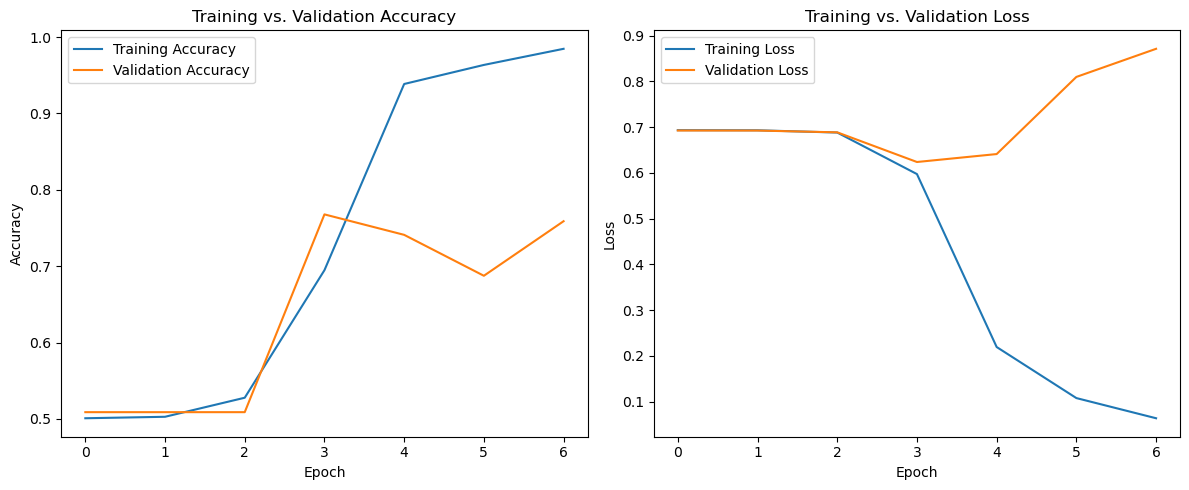

In [26]:
import matplotlib.pyplot as plt

#getting the final training epoch (Epoch 7)
final_epoch = len(history.history['loss']) - 1

#getting the best epoch with the lowest validation loss (Epoch 4)
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

#extracting metrics for final epoch
final_metrics = {
    'epoch': final_epoch + 1,
    'train_acc': history.history['accuracy'][final_epoch],
    'train_loss': history.history['loss'][final_epoch],
    'val_acc': history.history['val_accuracy'][final_epoch],
    'val_loss': history.history['val_loss'][final_epoch],
}

#extracting metric for best epoch
best_metrics = {
    'epoch': best_epoch + 1,
    'train_acc': history.history['accuracy'][best_epoch],
    'train_loss': history.history['loss'][best_epoch],
    'val_acc': history.history['val_accuracy'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
}

#displaying the results
print(f"Final Training Epoch (Epoch {final_metrics['epoch']}):")
print(f"Training Accuracy: {final_metrics['train_acc']:.4f}")
print(f"Training Loss: {final_metrics['train_loss']:.4f}")
print(f"Validation Accuracy: {final_metrics['val_acc']:.4f}")
print(f"Validation Loss: {final_metrics['val_loss']:.4f}\n")

print(f"Best Epoch (Epoch {best_metrics['epoch']} - lowest val loss):")
print(f"Training Accuracy: {best_metrics['train_acc']:.4f}")
print(f"Training Loss: {best_metrics['train_loss']:.4f}")
print(f"Validation Accuracy: {best_metrics['val_acc']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

plt.figure(figsize=(12, 5))

#plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<p>In the Training vs. Validation Accuracy visualization, training accuracy steadily increases and reaches near-perfect levels by Epoch 7, showing that the model learned patterns in the training data very well. However, validation accuracy peaks at Epoch 4 and slightly drops afterward. This gap between training and validation accuracy after Epoch 4 is a common sign that overfitting has started.</p>

<p>In the Training vs. Validation Loss visualization, training loss steadily decreases to a very low value of 0.06 by Epoch 7, showing that the model learned the training data well. However, validation loss drops until Epoch 4, then rises sharply, confirming that overfitting started after Epoch 4 and more training would've hurt validation performance.</p>

<p>At the final training epoch (Epoch 7), the model reached a training accuracy of 98%, training loss of 0.06, validation accuracy of 75%, and validation loss of 0.87. The large gap between training and validation metrics suggests overfitting, as the model performs much better on the training set than on the validation set. Because I used "restore_best_weights=True", the model reverted to the weights from Epoch 4, where validation loss was the lowest. So even though training technically stopped at Epoch 7, the model's final metrics come from Epoch 4, which had a training accuracy of 69%, training loss of 0.59, validation accuracy of 76%, and validation loss of 0.62. These results show a good balance between learning and generalization. The higher validation accuracy (76%) compared to training (69%) suggests that the model generalizes well to unseen data. Also, the small gap between training and validation metrics means overfitting had not started yet. The low validation loss at this point confirms that the model was performing at its best on validation data. Overall, the model achieves its best generalization at Epoch 4, as it has learned enough to perform well on new data while avoiding overfitting.</p>

<p>To reduce overfitting, I used early stopping with "patience=3" and "restore_best_weights=True" to stop training when the validation loss stopped improving. Training automatically stopped at Epoch 7 after no improvement was seen for 3 consecutive epochs. This prevented the model from continuing to learn patterns specific to the training data, helping reduce overfitting. With "restore_best_weights=True", the model reverted to the weights from Epoch 4, where the validation loss was lowest. This ensures that the final model used for evaluation is the one that generalized best to unseen data, not just the one that performed best on the training set. I also reduced overfitting by adding a dropout layer with a rate of 0.5 after the LSTM layer to randomly deactivate neurons during training. This prevents the model from relying too much on specific neurons, helping it generalize better. Additionally, I kept the model simple by using only 4 layers (embedding, LSTM, dropout, and dense) and limited the LSTM layer to 64 hidden units. This setup is enough to learn useful patterns without overcomplicating the model. Simpler models like this are less likely to overfit, especially when working with smaller datasets like IMDb.</p>

### D3. Provide clearly labeled visualizations of the model's training process and show the loss and accuracy metric

Final Training Epoch (Epoch 7):
Training Accuracy: 0.9846
Training Loss: 0.0634
Validation Accuracy: 0.7589
Validation Loss: 0.8715

Best Epoch (Epoch 4 - lowest val loss):
Training Accuracy: 0.6948
Training Loss: 0.5975
Validation Accuracy: 0.7679
Validation Loss: 0.6239


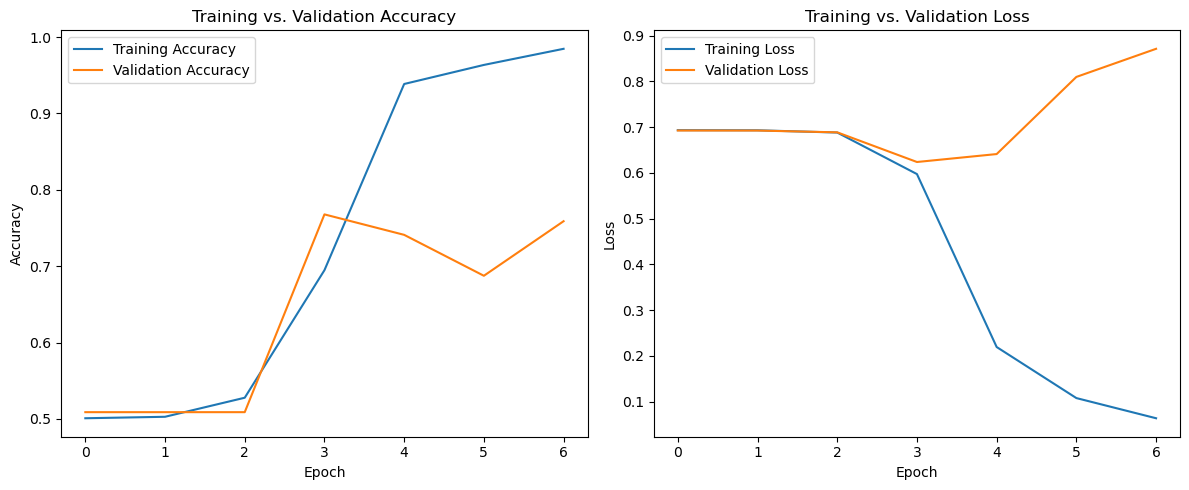

In [27]:
import matplotlib.pyplot as plt

#getting the final training epoch (Epoch 7)
final_epoch = len(history.history['loss']) - 1

#getting the best epoch with the lowest validation loss (Epoch 4)
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

#extracting metrics for final epoch
final_metrics = {
    'epoch': final_epoch + 1,
    'train_acc': history.history['accuracy'][final_epoch],
    'train_loss': history.history['loss'][final_epoch],
    'val_acc': history.history['val_accuracy'][final_epoch],
    'val_loss': history.history['val_loss'][final_epoch],
}

#extracting metric for best epoch
best_metrics = {
    'epoch': best_epoch + 1,
    'train_acc': history.history['accuracy'][best_epoch],
    'train_loss': history.history['loss'][best_epoch],
    'val_acc': history.history['val_accuracy'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
}

#displaying the results
print(f"Final Training Epoch (Epoch {final_metrics['epoch']}):")
print(f"Training Accuracy: {final_metrics['train_acc']:.4f}")
print(f"Training Loss: {final_metrics['train_loss']:.4f}")
print(f"Validation Accuracy: {final_metrics['val_acc']:.4f}")
print(f"Validation Loss: {final_metrics['val_loss']:.4f}\n")

print(f"Best Epoch (Epoch {best_metrics['epoch']} - lowest val loss):")
print(f"Training Accuracy: {best_metrics['train_acc']:.4f}")
print(f"Training Loss: {best_metrics['train_loss']:.4f}")
print(f"Validation Accuracy: {best_metrics['val_acc']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

plt.figure(figsize=(12, 5))

#plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<p>These two visualizations show the model's training progress over 7 epochs. In the Training vs. Validation Accuracy graph, training accuracy steadily increases, reaching about 98% by Epoch 7. However, validation accuracy peaks at Epoch 4 (around 76%) and then slightly declines, indicating the start of overfitting. In the Training vs. Validation Loss graph, training loss consistently decreases, while validation loss reaches its lowest point (0.62) at Epoch 4 then starts to rise, confirming overfitting beyond that point. These visualizations clearly highlight the benefit of early stopping. With "restore_best_weights=True", the model reverted to the weights from Epoch 4, where it performed best on the validation data.</p>

### D4. Discuss the predictive accuracy of the trained model using the chosen evaluation metric from part D3

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.7589
Test Loss: 0.6826


<p>I evaluated the predictive accuracy of the trained LSTM model using accuracy and loss metrics, which were also the chosen evaluation metrics in part D3. On the test set, the model achieved a test accuracy of 75.89% and a test loss of 0.6826. This means the model correctly predicted the sentiment of about 76% of the test reviews. The accuracy suggests that the model learned meaningful patterns and generalizes well to new data. The test loss of 0.6826 is also reasonable, suggesting that the model's prediction error is not too high and that it has good confidence in its predictions. These results are similar to the validation metrics during training, where validation accuracy peaked at 76.79% and validation loss reached its lowest value of 0.6239 at Epoch 4. This consistency shows that the model did not overfit to the training data and kept its ability to generalize. Using early stopping and dropout helped prevent overfitting, which supported the stable performance on the test set. Overall, the predictive accuracy and loss show that the model is effective at performing binary sentiment classification on unseen IMDb reviews.</p>

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


<Figure size 600x500 with 0 Axes>

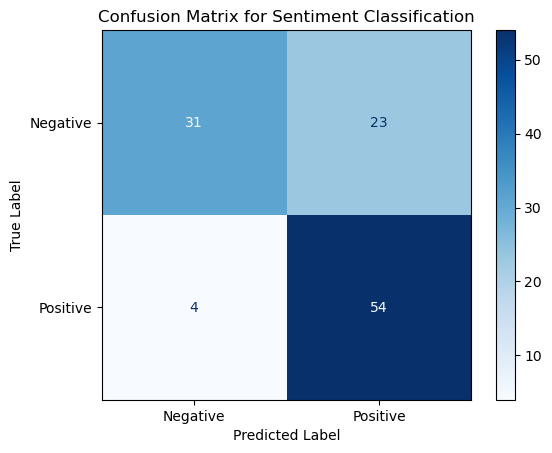

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#getting model predictions on test data
y_pred_probs = model.predict(X_test)
y_pred = np.round(y_pred_probs).astype(int).flatten()

#creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

#displaying the confusion matrix
plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for Sentiment Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

<p>I created a confusion matrix on the test set to further evaluate the predictive performance of the trained LSTM model. The matrix shows how well the model classified positive and negative reviews. According to the results, the model had 31 True Negatives (TN), 23 False Positives (FP), 4 False Negatives (FN), and 54 True Positives (TP). This means the model did a great job identifying positive reviews, with only 4 misclassified as negative. However, it struggled more with negative reviews, misclassifying 23 of them as positive. This suggests a slight bias toward the positive class. Still, the model performs well overall, supported by a test accuracy of 75.89% and a test loss of 0.6826.</p>

### D5. Explain how the analysis complies with artificial intelligence (AI) global ethical standards and mitigates bias

<p>This sentiment analysis follows global AI ethical standards by emphasizing fairness, transparency, and accountability throughout both data handling and model development. The IMDb dataset used is publicly available, well-documented, and widely used in research. In addition, all preprocessing steps that I performed in this analysis such as tokenization, padding, and labeling were applied consistently to all data. These practices promote transparency and make the analysis easy to understand and reproduce.</p>

<p>To support fairness and reduce bias, I checked the dataset for class balance. The number of positive and negative sentiment labels is nearly equal, which lowers the risk of the model favoring one class over the other. I also used stratified data splitting to ensure that the training, validation, and test sets maintain a similar distribution of positive and negative reviews. I applied early stopping to prevent overfitting, helping the model avoid memorizing training data that might not generalize fairly to new data. The model was then evaluated on a separate test set that it had never seen, providing an unbiased estimate of real-world performance.</p>

<p>To ensure accountability, I used clear and widely accepted evaluation metrics, such as accuracy and loss. I also included visualizations like training curves and a confusion matrix to clearly show how the model performed and behaved during training.</p>

<p>Lastly, in terms of privacy, the IMDb dataset contains no personal information, which makes it compliant with privacy standards such as the General Data Protection Regulation (GDPR).</p>

### E. Provide the code used to save the trained model within the neural network

In [30]:
#saving the trained LSTM model
model.save("sentiment_lstm_model.h5")

<p>In this code, I saved the trained LSTM model using the save() function. The file "sentiment_lstm_model.h5" is in HDF5 (.h5) format and it contains the full model architecture, weights, and optimizer state. I included this file in my submission.</p>

### F. Discuss the functionality of your model, including the impact of your choice of network architecture

<p>The purpose of my model is to classify IMDb movie reviews as either positive (1) or negative (0) using sentiment analysis. I built a neural network based on the Long Short-Term Memory (LSTM) architecture, which works well with sequential text data. Before feeding the data into the model, the reviews were tokenized, converted into integers, and padded to ensure all sequences were the same length, which is something that LSTM models require.</p>

<p>The model starts with an embedding layer that turns each word into a 50-dimensional vector, helping the model learn relationships between words. Next is an LSTM layer with 64 units, which captures the order and context of words, both of which are important for understanding sentiment. I added a dropout layer with a rate of 0.5 to reduce overfitting by randomly turning off some LSTM units during training. This helps improve generalization, especially with small datasets like IMDb. Finally, a dense layer with a sigmoid activation outputs the probability that a review is positive. This type of dense layer is ideal for binary classification tasks like this one.</p>

<p>I chose the LSTM architecture because it works well with sequential text data. Also, unlike standard RNNs, LSTMs avoid the vanishing gradient problem, which allows them to keep important information over longer text sequences. This is useful for understanding the full context in movie reviews. The LSTM model I used is simple but effective for a small dataset like IMDb. It achieved a test accuracy of 75.89% and a test loss of 0.6826, showing that it generalizes well to new reviews. Its simple structure, with only four layers, also makes it efficient and easy to understand. </p>

### G. Recommend a course of action based on your results as they relate to the research question

<p>The LSTM model I developed achieved a test accuracy of 75.89% and a test loss of 0.6826, showing that even a relatively simple neural network can accurately classify sentiment in movie reviews. This result has practical value for real-world organizations like movie studios and streaming platforms, where understanding audience sentiment helps with marketing, content selection, and personalized recommendations. Based on the results, several actions are recommended. First, the model can be connected to automated systems that analyze viewer feedback in real time across different platforms, helping stakeholders respond quickly to audience reactions. Second, the dataset can be expanded with more recent and diverse reviews to improve the model's accuracy and generalization. Third, more advanced models like Bidirectional LSTMs or transformers can be explored to better detect complex or sarcastic sentiments. Overall, the results suggest that a neural network can effectively perform sentiment analysis on movie reviews. By adding some improvements, this type of model can be a valuable tool for businesses looking to understand audience opinions and make smarter, data-driven decisions.</p>

### H. Submit a copy of your code and output in a PDF or HTML format

<p>I exported this notebook as an HTML file. The HTML file name is "d604task2rough.html", and I included it in my submission.</p>

### I. Submit a list of all the specific web sources you used to acquire segments of third-party code to support the application

<pre>

Otten, N. V. (2023, November 1). <i>How to Use LSTM in NLP tasks with a Text Classification Example Using Keras.</i> Spot Intelligence. https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/ 

Saxena, A. (2024, November 16). <i>Day 17: Building an LSTM Model for Sentiment Analysis.</i> Akansha Saxena. https://akanshasaxena.com/challenge/deep-learning/day_17/ 

Senaratne, R. (2021, October 18). <i>Long Short-Term Memory (LSTM) for Sentiment Analysis.</i> Medium. https://heartbeat.comet.ml/long-short-term-memory-lstm-for-sentiment-analysis-36f07900d360 
    
</pre>

### J. Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized

<pre>

Learning, V. (2024, August 14). <i>Understanding Dropout: A Key to Preventing Overfitting in Neural Networks.</i> Medium. https://vitalitylearning.medium.com/understanding-dropout-a-key-to-preventing-overfitting-in-neural-networks-21b28dd7c9b1

Natarajan, S. (2020, May 20). <i>Preprocessing Sequence Data in Keras(Padding & Masking Techniques).</i> Medium. https://shailaja21.medium.com/preprocessing-sequence-data-in-keras-padding-masking-techniques-aa087fe7319c 

Nyandwi, J. de D. (2021, November 20). <i>Early Stopping Explained!.</i> Medium. https://jeande.medium.com/early-stopping-explained-62eebce1127e 

Singhal, G. (2020, September 9). <i>Introduction to LSTM Units in RNN.</i> Pluralsight. https://www.pluralsight.com/resources/blog/guides/introduction-to-lstm-units-in-rnn 
    
Xu, Z. (2024, March 18). <i>Prevent the Vanishing Gradient Problem with LSTM.</i> Baeldung on Computer Science. https://www.baeldung.com/cs/lstm-vanishing-gradient-prevention
</pre>